In [1]:
#盗窃数据
import pandas as pd
# 读取数据
df = pd.read_csv("data/MPS_LSOA_Level_Crime_(Historical).csv")

# 筛选 major_category 为 Theft
df_theft = df[df["Major Category"].str.upper().str.contains("THEFT")]

# 筛选出列名是数字的
date_cols = [col for col in df_theft.columns if col.isdigit()]

# 只保留 201501–201912
date_cols = [col for col in date_cols if "201501" <= col <= "201912"]

# 再选出其他保留列（如 LSOA 代码 / 名称）
keep_cols = ["LSOA Code", "LSOA Name", "Borough", "Minor Category"] + date_cols
df_filtered = df_theft[keep_cols]

# 转换成长格式
df_long = df_filtered.melt(
    id_vars=["LSOA Code", "LSOA Name", "Minor Category"],
    value_vars=[col for col in df_filtered.columns if col.isdigit() and "201501" <= col <= "201912"],
    var_name="Month", value_name="Count"
)

# 增加年份column
df_long["Year"] = df_long["Month"].str[:4].astype(int)

# 计算每年的总和
df_yearly = (
    df_long
    .groupby(["LSOA Code", "Year"])["Count"]
    .sum()
    .reset_index()
    .rename(columns={"Count": "Theft Count"})
)

print(df_yearly.shape)
print(df_yearly.head())
print(df_yearly.isnull().sum())
print(df_yearly.dtypes)


(24940, 3)
   LSOA Code  Year  Theft Count
0  E01000006  2015            3
1  E01000006  2016            8
2  E01000006  2017            9
3  E01000006  2018           15
4  E01000006  2019            6
LSOA Code      0
Year           0
Theft Count    0
dtype: int64
LSOA Code      object
Year            int64
Theft Count     int64
dtype: object


In [2]:
#人口数据

# 导入
pop = pd.ExcelFile("data/sapelsoabroadage20112022.xlsx")
sheet_names = pop.sheet_names

# 定义需要的数据
target_sheets =['Mid-2015 LSOA 2021', 'Mid-2016 LSOA 2021', 'Mid-2017 LSOA 2021', 'Mid-2018 LSOA 2021', 'Mid-2019 LSOA 2021']
target_year = {'Mid-2015 LSOA 2021': 2015, 'Mid-2016 LSOA 2021': 2016, 'Mid-2017 LSOA 2021': 2017, 'Mid-2018 LSOA 2021': 2018, 'Mid-2019 LSOA 2021': 2019}

# 合并所有需要的数据表
pop_list=[]
for sheet in target_sheets:
    df_pop = pop.parse(sheet, skiprows=3, header=0)
    df_pop.columns = df_pop.columns.str.strip()
    df_pop = df_pop.rename(columns={
        "LSOA 2021 Code": "LSOA Code",
        "Total": "Population"
    })
    df_pop["Year"] = target_year[sheet]
    df_pop["Vulnerable_Group"] = df_pop["M65 and over"] + df_pop["F65 and over"] + df_pop["F0 to 15"] + df_pop["M0 to 15"]
    df_pop["Vulnerable_Ratio"] = df_pop["Vulnerable_Group"] / df_pop["Population"]

    pop_list.append(df_pop[["LSOA Code", "Year", "Population", "Vulnerable_Ratio"]])

pop_fin = pd.concat(pop_list, ignore_index=True)

# 伦敦数据
london_lsoa = df_yearly["LSOA Code"].unique()

london_pop = pop_fin[pop_fin["LSOA Code"].isin(london_lsoa)]

print(london_pop.shape)
print(london_pop.head())
print(london_pop.isnull().sum())
print(london_pop.dtypes)

(24940, 4)
       LSOA Code  Year  Population  Vulnerable_Ratio
28767  E01000006  2015        1929          0.325557
28768  E01000007  2015        2158          0.297498
28769  E01000008  2015        1650          0.374545
28770  E01000009  2015        1737          0.298791
28771  E01000011  2015        1647          0.313297
LSOA Code           0
Year                0
Population          0
Vulnerable_Ratio    0
dtype: int64
LSOA Code            object
Year                  int64
Population            int64
Vulnerable_Ratio    float64
dtype: object


In [3]:
# 清洗人口密度数据
# 导入
den = pd.ExcelFile("data/sapelsoapopulationdensity20112022.xlsx")
sheet_names_den = den.sheet_names

df_den = den.parse(sheet_name="Mid-2011 to mid-2022 LSOA 2021", skiprows=3, header=0)
df_den.columns = df_den.columns.str.strip()
df_den = df_den.rename(columns={"LSOA 2021 Code": "LSOA Code",
                                "Mid-2015: People per Sq Km": "2015",
                                "Mid-2016: People per Sq Km": "2016",
                                "Mid-2017: People per Sq Km": "2017",
                                "Mid-2018: People per Sq Km": "2018",
                                "Mid-2019: People per Sq Km": "2019"})
keep_cols2 = ["LSOA Code", "2015", "2016", "2017", "2018", "2019"]
df_den = df_den[keep_cols2]


# 转换长格式
den_long = pd.melt(df_den, 
                   id_vars=["LSOA Code"], 
                   var_name="Year", 
                   value_name="Population Density")

den_long["Year"] = den_long["Year"].astype(int)
den_long["LSOA Code"] = den_long["LSOA Code"].astype(str)

# 筛选伦敦
london_den = den_long[den_long["LSOA Code"].isin(london_lsoa)]

print(london_den.shape)
print(london_den.head())
print(london_den.isnull().sum())
print(london_den.dtypes)


(24940, 3)
   LSOA Code  Year  Population Density
4  E01000006  2015        13158.253752
5  E01000007  2015        10790.000000
6  E01000008  2015         8522.727273
7  E01000009  2015        13580.922596
8  E01000011  2015        17960.741549
LSOA Code             0
Year                  0
Population Density    0
dtype: int64
LSOA Code              object
Year                    int64
Population Density    float64
dtype: object


In [4]:
# 房价数据
housing = pd.ExcelFile("data/hpssadataset46medianpricepaidforresidentialpropertiesbylsoa/median_price.xlsx")
sheet_names_housing = housing.sheet_names

df_housing = housing.parse(sheet_name="1a", skiprows=5, header=0)
df_housing.columns = df_housing.columns.str.strip()
df_housing = df_housing.rename(columns={"LSOA code": "LSOA Code"})
df_housing = df_housing[df_housing["LSOA Code"].isin(london_lsoa)]

# melt 所有列（除了 LSOA code、name）变成行
housing_long = pd.melt(df_housing, 
                  id_vars=["LSOA Code"], 
                  var_name="Date", 
                  value_name="House Price")

# 提取 4 位数年份作为新的一列
housing_long["House Price"] = pd.to_numeric(housing_long["House Price"], errors="coerce")

# 再安全地转成整数
housing_long["Year"] = housing_long["Date"].str.extract(r"(\d{4})")
housing_long = housing_long.dropna(subset=["Year"])
housing_long["Year"] = housing_long["Year"].astype(int)
housing_yearly = housing_long.groupby(["LSOA Code", "Year"])["House Price"].mean().reset_index()

london_housing = housing_yearly[housing_yearly["LSOA Code"].isin(london_lsoa)&
    (housing_yearly["Year"].between(2015, 2019))]

print(london_housing.shape)
print(london_housing.head())
print(london_housing.isnull().sum())
print(london_housing.dtypes)

(23265, 3)
    LSOA Code  Year  House Price
20  E01000006  2015     196125.0
21  E01000006  2016     349062.5
22  E01000006  2017     408500.0
23  E01000006  2018     379375.0
24  E01000006  2019     247375.0
LSOA Code        0
Year             0
House Price    542
dtype: int64
LSOA Code       object
Year             int64
House Price    float64
dtype: object


In [5]:
# 补房价空缺值
london_housing["House Price"] = london_housing.groupby("LSOA Code")["House Price"].transform(lambda x: x.fillna(x.mean()))
london_housing["House Price"] = london_housing["House Price"].fillna(london_housing["House Price"].median())
print(london_housing.head())
print(london_housing.isnull().sum())
print(london_housing.dtypes)

    LSOA Code  Year  House Price
20  E01000006  2015     196125.0
21  E01000006  2016     349062.5
22  E01000006  2017     408500.0
23  E01000006  2018     379375.0
24  E01000006  2019     247375.0
LSOA Code      0
Year           0
House Price    0
dtype: int64
LSOA Code       object
Year             int64
House Price    float64
dtype: object


C:\Users\hp\AppData\Local\Temp\ipykernel_15908\3209577664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_housing["House Price"] = london_housing.groupby("LSOA Code")["House Price"].transform(lambda x: x.fillna(x.mean()))
C:\Users\hp\AppData\Local\Temp\ipykernel_15908\3209577664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_housing["House Price"] = london_housing["House Price"].fillna(london_housing["House Price"].median())


In [6]:
# imd数据
IMD = pd.ExcelFile("data/File_5_-_IoD2019_Scores.xlsx")

sheet_names_IMD = IMD.sheet_names

df_IMD = IMD.parse(sheet_name="IoD2019 Scores", header=0)
df_IMD.columns = df_IMD.columns.str.strip()
df_IMD = df_IMD.rename(columns={"LSOA code (2011)": "LSOA Code"})
df_IMD = df_IMD[df_IMD["LSOA Code"].isin(london_lsoa)]

keep_cols3 = ["LSOA Code", "Income Score (rate)", 
              "Employment Score (rate)", 
              "Education, Skills and Training Score", 
              "Health Deprivation and Disability Score", 
              "Barriers to Housing and Services Score", 
              "Living Environment Score"]
IMD_fin = df_IMD[keep_cols3]

print(IMD_fin.shape)
print(IMD_fin.isnull().sum())
print(IMD_fin.dtypes)

(4653, 7)
LSOA Code                                  0
Income Score (rate)                        0
Employment Score (rate)                    0
Education, Skills and Training Score       0
Health Deprivation and Disability Score    0
Barriers to Housing and Services Score     0
Living Environment Score                   0
dtype: int64
LSOA Code                                   object
Income Score (rate)                        float64
Employment Score (rate)                    float64
Education, Skills and Training Score       float64
Health Deprivation and Disability Score    float64
Barriers to Housing and Services Score     float64
Living Environment Score                   float64
dtype: object


In [7]:
# 筛选lsoa2011
lsoa11 = IMD_fin["LSOA Code"].unique()

df_yearly = df_yearly[df_yearly["LSOA Code"].isin(lsoa11)]
london_pop = london_pop[london_pop["LSOA Code"].isin(lsoa11)]
london_den = london_den[london_den["LSOA Code"].isin(lsoa11)]
london_housing = london_housing[london_housing["LSOA Code"].isin(lsoa11)]

In [8]:
# 合并数据集
df_model = df_yearly.copy()
df_model = df_model.merge(london_pop, on=["LSOA Code", "Year"], how="left")
df_model = df_model.merge(london_den, on=["LSOA Code", "Year"], how="left")
df_model = df_model.merge(london_housing, on=["LSOA Code", "Year"], how="left")

print(df_model.head())
print(df_model.shape)
print(df_model.isnull().sum())

   LSOA Code  Year  Theft Count  Population  Vulnerable_Ratio  \
0  E01000006  2015            3        1929          0.325557   
1  E01000006  2016            8        1882          0.319872   
2  E01000006  2017            9        1852          0.322894   
3  E01000006  2018           15        1844          0.329176   
4  E01000006  2019            6        1844          0.315076   

   Population Density  House Price  
0        13158.253752     196125.0  
1        12837.653479     349062.5  
2        12633.015007     408500.0  
3        12578.444748     379375.0  
4        12578.444748     247375.0  
(23265, 7)
LSOA Code             0
Year                  0
Theft Count           0
Population            0
Vulnerable_Ratio      0
Population Density    0
House Price           0
dtype: int64


In [9]:
# 每千人盗窃率
df_model["Theft_Rate_per1k"] = df_model["Theft Count"] / df_model["Population"] * 1000


In [10]:
# 合并静态数据集
df_model = df_model.merge(IMD_fin, on="LSOA Code", how="left")

In [11]:
# 删掉不需要的数据
df_model = df_model.drop(columns=["Theft Count", "Population"])

# 修改column名字
df_model.columns = df_model.columns.str.replace(" ", "_")
df_model.columns = df_model.columns.str.replace(r"[()/]", "", regex=True)

print(df_model.head())
print(df_model.shape)
print(df_model.isnull().sum())

   LSOA_Code  Year  Vulnerable_Ratio  Population_Density  House_Price  \
0  E01000006  2015          0.325557        13158.253752     196125.0   
1  E01000006  2016          0.319872        12837.653479     349062.5   
2  E01000006  2017          0.322894        12633.015007     408500.0   
3  E01000006  2018          0.329176        12578.444748     379375.0   
4  E01000006  2019          0.315076        12578.444748     247375.0   

   Theft_Rate_per1k  Income_Score_rate  Employment_Score_rate  \
0          1.555210              0.117                  0.059   
1          4.250797              0.117                  0.059   
2          4.859611              0.117                  0.059   
3          8.134490              0.117                  0.059   
4          3.253796              0.117                  0.059   

   Education,_Skills_and_Training_Score  \
0                                14.798   
1                                14.798   
2                                14.798  

In [12]:
df_model.to_csv("data/cleaned_data.csv", index=False)

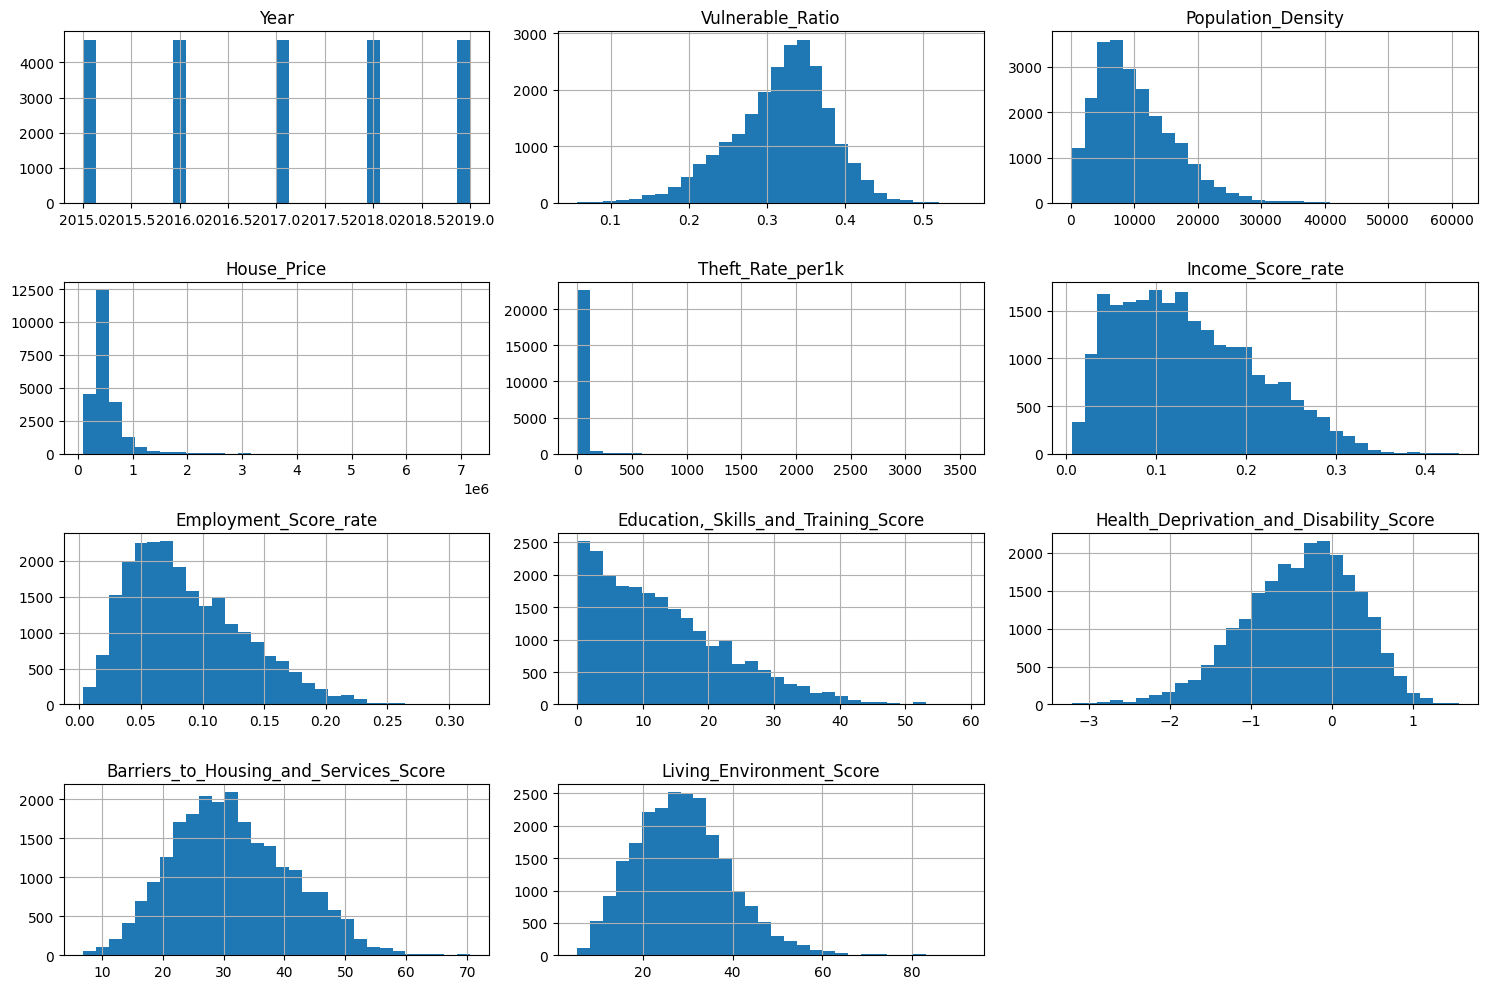

In [13]:
# 直方图
import matplotlib.pyplot as plt
df_model.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler

features = df_model.drop(columns=["Theft_Rate_per1k", "LSOA_Code", "Year", "Employment_Score_rate"])  # 你要预测的那个记得留出来
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = pd.DataFrame(features_scaled, columns=features.columns)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                                   feature       VIF
0                         Vulnerable_Ratio  2.047707
1                       Population_Density  1.673635
2                              House_Price  1.556342
3                        Income_Score_rate  4.473994
4     Education,_Skills_and_Training_Score  2.467608
5  Health_Deprivation_and_Disability_Score  3.433570
6   Barriers_to_Housing_and_Services_Score  1.556813
7                 Living_Environment_Score  1.683996


In [22]:
import statsmodels.api as sm

X = sm.add_constant(X)  # 加常数项
y = df_model["Theft_Rate_per1k"]
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Theft_Rate_per1k   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     472.3
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:08:18   Log-Likelihood:            -1.3025e+05
No. Observations:               23265   AIC:                         2.605e+05
Df Residuals:                   23256   BIC:                         2.606e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------